In [ ]:
import cv2
import glob
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from skimage import data, io, filters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/combined_pollen.zip','r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
len(os.listdir('/tmp/combined_pollen/'))
path = '/tmp/combined_pollen/'
names = [name.replace(' ', '_').split('_')[0] for name in os.listdir('/tmp/combined_pollen/')]
y_train = names

In [ ]:
type(y_train)
y_train = np.array(y_train).astype(np.float32)


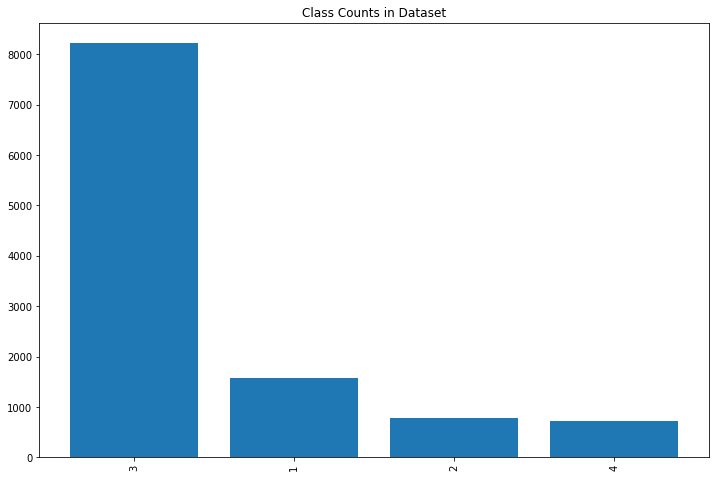

In [ ]:
from collections import Counter
classes = Counter(names) 
plt.figure(figsize = (12,8))
plt.title('Class Counts in Dataset')
plt.bar(*zip(*classes.items()))
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
#resizing the images
'''
def process_img(img, size = (128,128)):
    img = cv2.resize(img, size)  # resize image (did not work)
    img = img/255                # devide values to 255
    return img
    '''
X, Y=[], []
for images in os.listdir(path):
  img = io.imread(path + images)
  X.append(img)
  Y.append(images.replace(' ', '_').split('_')[0])

X = np.array(X)


In [ ]:
#onehot encoding y-label
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
label = LabelEncoder()
Y_label = label.fit_transform(Y)
Y_categotical = np_utils.to_categorical(Y_label, 4)

In [ ]:
path_class  = {key:[] for key in classes.keys()}

for name in os.listdir(path):
    key = name.replace(' ', '_').split('_')[0]
    path_class[key].append(path + name)

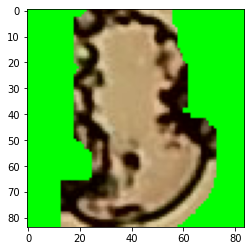

In [ ]:
from PIL import Image #just for visualization 
for i, key in enumerate(path_class.keys()):
   class1 = Image.open(path_class[key][0]) 
   plt.imshow(class1)

In [ ]:
IMG_SHAPE = (84, 84, 3)
model0 = tf.keras.applications.EfficientNetB3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
tf.keras.utils.plot_model(model0) # to draw and visualize
model0.summary() # to see the list of layers and parameters

43950080/43941136 [==============================] - 0s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.877554 to fit

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 84, 84, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 84, 84, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 

**EfficientNetB3**

In [ ]:
!pip install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-hnf1v8d6
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-hnf1v8d6
     |████████████████████████████████| 50 kB 3.0 MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=1a8e8e353f0a4073e28b9fb9b2c875b2b42ba8da955705441bf8a030ad9e1b91
  Stored in directory: /tmp/pip-ephem-wheel-cache-6jjo4mc8/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 
from keras import optimizers

In [ ]:
#model
img_size = 84
units = 4
model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

In [ ]:
model.trainable = False #freezing

In [ ]:
#adding more layers
from tensorflow.keras import optimizers
from keras.layers import BatchNormalization
x = model.output
#x = Flatten()(x) #more params
x=GlobalAveragePooling2D()(x) #less params
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(units, activation="softmax")(x)
model_final = Model(inputs = model.input, outputs = predictions)

model_final.compile(optimizers.RMSprop(lr=0.0001, epsilon=1e-6), loss='categorical_crossentropy', metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 84, 84, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 84, 84, 3)    7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 85, 85, 3)    0           normalization_1[0][0]            
______________________________________________________________________________________________

In [ ]:
#importing the test data
test_zip = zipfile.ZipFile('/content/drive/MyDrive/testimages.zip','r')
test_zip.extractall('/tmp')
test_zip.close()

In [ ]:
len(os.listdir('/tmp/testimages/'))
path_test = '/tmp/testimages/'

In [ ]:
Xtest = []
for images in os.listdir(path_test):
  img = io.imread(path_test + images)
  Xtest.append(img)
X_test = np.array(Xtest)

In [ ]:
train_history = model_final.fit(X, Y_categotical, batch_size=128, epochs=30, verbose=2, validation_split =0.30)#use class_weights later

Epoch 1/30
62/62 - 63s - loss: 0.6075 - accuracy: 0.7842 - val_loss: 0.4154 - val_accuracy: 0.8626
Epoch 2/30
62/62 - 17s - loss: 0.4476 - accuracy: 0.8465 - val_loss: 0.3621 - val_accuracy: 0.8848
Epoch 3/30
62/62 - 17s - loss: 0.3970 - accuracy: 0.8650 - val_loss: 0.3561 - val_accuracy: 0.8836
Epoch 4/30
62/62 - 17s - loss: 0.3708 - accuracy: 0.8731 - val_loss: 0.3415 - val_accuracy: 0.8833
Epoch 5/30
62/62 - 17s - loss: 0.3491 - accuracy: 0.8792 - val_loss: 0.3088 - val_accuracy: 0.8948
Epoch 6/30
62/62 - 17s - loss: 0.3389 - accuracy: 0.8877 - val_loss: 0.3032 - val_accuracy: 0.8983
Epoch 7/30
62/62 - 17s - loss: 0.3299 - accuracy: 0.8922 - val_loss: 0.3377 - val_accuracy: 0.8883
Epoch 8/30
62/62 - 17s - loss: 0.3258 - accuracy: 0.8934 - val_loss: 0.2994 - val_accuracy: 0.9007
Epoch 9/30
62/62 - 17s - loss: 0.3073 - accuracy: 0.8979 - val_loss: 0.2953 - val_accuracy: 0.9051
Epoch 10/30
62/62 - 17s - loss: 0.3061 - accuracy: 0.8994 - val_loss: 0.2786 - val_accuracy: 0.9093
Epoch 11/

In [ ]:
# fetching y labels from json file
names_test = [name for name in os.listdir('/tmp/testimages/')]

In [ ]:
import json
from itertools import islice
#data = json.load(open('test_labels.json', 'r'))

with open('test_labels.json') as data_file:    
    data = json.load(data_file)
    for j in range(len(data)):
      z = data[j]
      first, second = islice(z.values(), 2)
      for i in range(len(names_test)):
        if first == names_test[i]:
          names_test[i] = second


In [ ]:
names_test = np.array(names_test)

In [ ]:
label_test = LabelEncoder()
Y_testlabel = label_test.fit_transform(names_test)
Y_testlabel = np_utils.to_categorical(Y_testlabel, 4)

**TESTING**

In [ ]:
model_final.evaluate(X_test, Y_testlabel, batch_size = 128,verbose = 1)

16/16 [==============================] - 4s 260ms/step - loss: 0.6875 - accuracy: 0.7785


[0.6875332593917847, 0.7785032391548157]